# Extract low-pass LFPs

Extract low-pass LFPs from selected trials. 

In [15]:
# notebook configuration and Python 2/3 compatibility imports
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import
from __future__ import with_statement
from __future__ import division
from __future__ import nested_scopes
from __future__ import generators
from __future__ import unicode_literals
from __future__ import print_function

print('Ready')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ready


In [16]:
# A partial copy of m. rule's neurotools package is bundled with this example
# The full package is on github, but is unstable "research" quality code. 
import neurotools_partial
from neurotools_partial.spatial.dct import *
from neurotools_partial.spatial.array import *
from neurotools_partial.spatial.phase import *
from neurotools_partial.spatial.fftzeros import *
from neurotools_partial.jobs.parallel import *
from neurotools_partial.signal.signal import remove_short

from scipy.io import loadmat
from pylab import *

## Constants

In [17]:
Fs       = 1000 # Samples per second
Espacing = 0.4  # Inter-electrode spacing in mm

# PMv wave diversity example

1. Load data
2. Plot data
3. Critical points
4. Wave classification

## Load data

In [18]:
session = 'SPK120918'
area    = 'PMv'
name    = '%s_%s_analytic_beta_LFP_select_trials'%(session,area)
data    = loadmat(name,squeeze_me=True)
x       = data['betaAnalyticLFP1kHz']
fa      = data['fa']
fb      = data['fb']
fmid    = sqrt(fa*fb)
Ntrials, Nrows, Ncols, Nms = x.shape

print(data['README'])
print('\n====Summary of %s===='%name)
print('Beta range %d - %d Hz'%(fa,fb))
print('%d trials'%Ntrials)
print('%d ms per trial'%Nms)
print('%d x %d spatial grid'%(Nrows, Ncols))


This archive contains selected spatiotemporal beta-LFP from the Cued Grasp 
with Instructed Delay (CGID) task for session SPK120918 area PMv. These data are
provided for illustration purposes only, to demonstrate routines for 
calculating spatiotemporal phase statistics on multi-electrode arrays.
This archive includes data only from the one-second period before the 
object illumination in the CGID task.

The variables are as follows:

README:
    This message

betaAnalyticLFP1kHz:
    Ntrials x 10 x 10 x Ntimes complex-valued array of beta-LFP analytic signals
    For each trial, there is a 10 x 10 grid of beta-LFP analytic signals, 
    sampled at 1 kHz. LFP have been extracted using 4th order Butterworth 
    filtering applied forwards and backwards, with a low-frequency cutoff of 
    18.6 Hz and a high-frequency cutoff of 23.6 Hz. Analytic signals are 
    constructed using the Hilbert transform.

Ntrials : int
    Number of select trials provided for example

fa : float
    Beta-

## Preview data

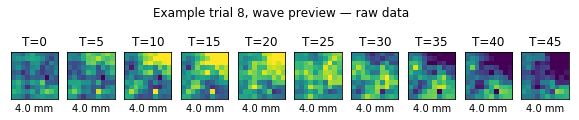

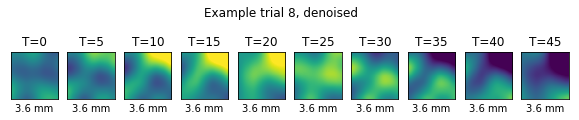

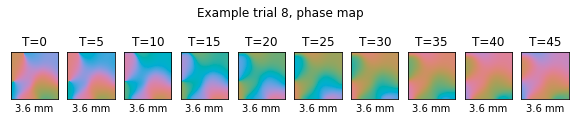

In [ ]:
############################################################
# Plotting configuration
tidx     = 7   # which trial to preview
smooth   = 2.0 # mm: smoothing radius for denoising
upsample = 16  # Upsampling factor for plotting
skip     = 5   # show every `skip` samples
vrange   = 20  # millivolts; signal range

############################################################
# Plot raw data
figure(figsize=(10,2))
for i in range(10):
    time = i*skip
    subplot(1,10,i+1)
    imshow(x[tidx,:,:,time].real,vmin=-vrange,vmax=vrange)
    title('T=%d'%time)
    xticks([]); yticks([])
    xlabel('%0.1f mm'%(Ncols*Espacing))
suptitle('Example trial %d, wave preview — raw data'%(tidx+1))
show()

############################################################
# Plot denoised example
figure(figsize=(10,2))
for i in range(10):
    time = i*skip
    subplot(1,10,i+1)
    w = dct_upsample(dct_cut_antialias(x[tidx,:,:,time],smooth),upsample)
    imshow(w.real,vmin=-vrange,vmax=vrange)
    title('T=%d'%time)
    xticks([]); yticks([])
    xlabel('%0.1f mm'%(Espacing*(Ncols-1)))
suptitle('Example trial %d, denoised'%(tidx+1));

############################################################
# Plot phase maps
figure(figsize=(10,2))
for i in range(10):
    time = i*skip
    subplot(1,10,i+1)
    w = dct_upsample(dct_cut_antialias(x[tidx,:,:,time],smooth),upsample)
    imshow(np.angle(w),cmap = isolum, vmin=-pi, vmax=pi)
    title('T=%d'%time)
    xticks([]); yticks([])
    xlabel('%0.1f mm'%(Espacing*(Ncols-1)))
suptitle('Example trial %d, phase map'%(tidx+1));

## Parallelize critical-point detection over frames

Critical point detection is computationally intensive. Analytic signals are upsampled and smoothed, denoising the data and focusing on the mesoscopic spatial scale. Radiating and saddle critical points are estimated by looking for critical points in the discrete derivative. Rotating centers are detected by a contour integral around each point, computed as a convolution

In [ ]:
# Define critical-point parallization helper routine
def critical_helper(params):
    (i,x) = params
    x = dct_upsample(dct_cut_antialias(x,smooth),4)
    clockwise, anticlockwise, saddles, peaks, maxima, minima = find_critical_points(x,edgeavoid=6)
    return i,tuple(map(len,(clockwise, anticlockwise, maxima, minima)))
reset_pool()

# Set up the parallel problem and compute in parallel
problems = [frame for tidx in range(Ntrials) for frame in x[tidx].transpose(2,0,1)]

# If something goes on, try again with debug=True,
# this will run all jobs from the main process, making it
# easier to trace errors.
cps      = parmap(critical_helper,enumerate(problems),debug=False)

# Repack results into Ntrials x 4 x Nms
critical = array(cps).reshape((Ntrials,Nms,4)).transpose((0,2,1))
print('Done')


done 91.3% 

## Compute spatiotemporal summary statistics

These include the spatially-averaged β-LFP amplitude envelope, an amplitude-weighted synchrony statistic similar to the Kuramoto order parameter, and a phase-gradient directionality measure. 

In [ ]:
amplitudes = array(list(map(array_average_amplitude,x)))
pgd        = array(list(map(array_synchrony_pgd,x)))
pgdstd     = sqrt(-2*log(pgd)) # Convert to units of radians
syn        = population_synchrony(x,axis=(1,2))
std        = sqrt(-2*log(syn)) # Convert to units of radians

## Define threshold for wave categorization

Thresholds here differ from the ones used in the paper, which were computed based on statistics across all three areas. Wave transitions are often continuous an no clear clusters emerge, but subjective thresholds can be set to qualitatively, approximately, summarize the diversity and variability.

In [ ]:
# These thresholds are for illustration purposes only
high_beta             = 15      # mV
phase_gradient_sigma  = pi*0.25 # radians
phase_synchrony_sigma = pi*0.25 # radians

## Plot example wave events

These are heuristic qualitative categories. Wave patterns transition continuously between different states, and many edge-cases exist where waves belong to more than one category. For example, highly synchronous states can also exhibit spatial structure, such as planar or rotating waves. For this reason (along with other evidence presented in the paper), we argue that waves exist on a continuum between disorganized, complex spatial structure, to spatially synchronized structure at higher β-LFP amplitudes. Synchrony emerges as the limiting case of long-wavelength planar, rotating, or complex waves.

(examples are selected randomly; re-run the code-block below to observe different examples for rotating, radiating)

In [ ]:
import random

############################################################
# Compute heuristic, qualitative wave categorization
# (this is inexact, mainly used to summarize qualitative
#  diversity; variability is continuous and ambiguous
#  edge-cases exist)
# Get critical point counts
Ndata = Ntrials*Nms
cps   = array(critical).transpose((1,0,2)).reshape((4,Ndata)) #critical[tidx]
clockwise, anticlockwise, maxima, minima = cps
rotating = clockwise+anticlockwise
peaks    = maxima+minima
# Identify periods of radiating / rotating
rotating  = (rotating==1) & (peaks   ==0)
radiating = (peaks   ==1) & (rotating==0)
ncrit     = sum(cps,axis=0)
complexs  = ncrit>1
# Detect plane wave, high-beta, and synchrony events
high  = amplitudes.reshape((Ndata,)) > high_beta
plane = pgdstd.reshape((Ndata,))     < phase_gradient_sigma
synch = std.reshape((Ndata,))        < phase_synchrony_sigma

############################################################
# Categories are subjective and overlap; 
# Make categories mutually exclusive 
# (heuristic) for qualitative summary. 
exclude    = plane.copy()
radiating &=~exclude
exclude   |= radiating
rotating  &=~exclude
exclude   |= rotating
synch     &=~exclude 
complexs  &=~exclude

############################################################
# For illustration, truncate at the period of a beta oscillation
# Averages in the paper were computed without truncating, in order 
# to faithfully summarize the overall distribution.
tooshort  = round(Fs/fmid)
high      = remove_short(high ,tooshort)
plane     = remove_short(plane,tooshort)
synch     = remove_short(synch,tooshort)
rotating  = remove_short(rotating ,tooshort)
radiating = remove_short(radiating,tooshort)
complexs  = remove_short(complexs ,tooshort)

############################################################
# Locate an illustrative trile with wave diversity
diverse = \
    (sum(complexs .reshape((Ntrials,Nms)),axis=1)>40) &\
    (sum(synch    .reshape((Ntrials,Nms)),axis=1)>40) &\
    (sum(radiating.reshape((Ntrials,Nms)),axis=1)>40) &\
    (sum(rotating .reshape((Ntrials,Nms)),axis=1)>40) &\
    (sum(high     .reshape((Ntrials,Nms)),axis=1)>40)
tr    = random.choice(find(diverse))
times = arange(Nms)/1000.0
a     = tr*Nms
b     = a + Nms
subplot(211)
fill_between(times,0,complexs[a:b]  ,color=WHITE    ,linewidth=0,label="Complex"    )
fill_between(times,0,synch[a:b]     ,color=RUST     ,linewidth=0,label="Synchronous")
fill_between(times,0,radiating[a:b] ,color=AZURE    ,linewidth=0,label="Radiating"  )
fill_between(times,0,rotating[a:b]  ,color=TURQUOISE,linewidth=0,label="Rotating"   )
fill_between(times,1,high[a:b]*0.5+1,color=BLACK    ,linewidth=0,label="High-beta"  )
ylim(0,1.5); 
noy()
legend(bbox_to_anchor=(1.04,1), loc="upper left")
title('Qualitative categorization trial %d, pre-object period'%tr)

############################################################
# Identify example events
# There are no plane waves in PMv so skip those    
tsynch = argmin(std.reshape((Ndata,)))
# In the paper, waves with many critical points "complex"
# are lumped with ambiguous "unclassified" waves. For 
# illustration, locate a "true" complex wave by searching
# times that are also asynchronous
async  = std.reshape((Ndata,))>pi/2
tcompl = argmax(ncrit * async * high)
tcompl   = (random.choice(find((ncrit>3)&async)))
trot   = (random.choice(find(( rotating==1)&(radiating==0)&(ncrit==1)&async)))
trad   = (random.choice(find((radiating==1)&( rotating==0)&(ncrit==1)&async)))
xlabel('Time (s)')

############################################################
# Re-order trial, time wave data into a single block
# in order to retrieve wave data for each example.
xcat = x.transpose((1,2,0,3))
xcat = xcat.reshape((Nrows,Ncols,Ntrials*Nms))

############################################################
# Plot wave example from each category
subplot(212)
egt  = array([tsynch,trot,trad,tcompl])
egs  = array('Sync Rotate Radiate Complex'.split())
for i,(time,name) in enumerate(zip(egt,egs)):
    subplot(2,4,i+5)
    w = dct_upsample(dct_cut_antialias(xcat[:,:,int(time)],smooth),upsample)
    edgeavoid=int(ceil(upsample*1.5))
    a = np.angle(w)[edgeavoid:-edgeavoid,edgeavoid:-edgeavoid]
    imshow(a,cmap = double_isolum, vmin=-pi, vmax=pi)
    noaxis(); nox(); noy()
    t  = time  % 1000
    tr = time // 1000
    title(name+'\ntrial %d\nT=%d ms'%(tr,t))
    if name in ('Radiate','Rotate','Complex'):
        # Ignore critical points during synchronous waves,
        # which represent small fluctuations about the 
        # synchronous state.
        clock, anticlock, _, _, maxima, minima = find_critical_points(w,
            edgeavoid=edgeavoid) # Trim edges to remove boundary effects
        for px,py in list(clock) + list(anticlock) + list(maxima) + list(minima):
            scatter([px-edgeavoid],[py-edgeavoid],color=BLACK)
    
subplots_adjust(hspace=1.2,wspace=0.3)

# M1 wavelength calculation demo

Plane-wave events consistent with previously published observations were seen in areas M1 and PMd in both subjects. To attenuate effects of noise on wavelength estimates, we use a more stringent cutoff in the phase-gradient directionality measure. In both subjects, area M1 showed a sufficient number of plane waves that met this more stringent criterion.


1. Load data
2. Plot data
4. Wavelength

### Load data from disk

In [ ]:
session = 'SPK120918'
area    = 'M1'
name    = '%s_%s_analytic_beta_LFP_select_trials'%(session,area)
data    = loadmat(name,squeeze_me=True)
x       = data['betaAnalyticLFP1kHz']
fa      = data['fa']
fb      = data['fb']
fmid    = sqrt(fa*fb)
Ntrials, Nrows, Ncols, Nms = x.shape

print(data['README'])
print('\n====Summary of %s===='%name)
print('Beta range %d - %d Hz'%(fa,fb))
print('%d trials'%Ntrials)
print('%d ms per trial'%Nms)
print('%d x %d spatial grid'%(Nrows, Ncols))

### Preview wave data

In [ ]:
############################################################
# Plotting configuration
tidx     = 0   # which trial to preview
smooth   = 2.0 # mm: smoothing radius for denoising
upsample = 16  # Upsampling factor for plotting
skip     = 7  # show every `skip` samples
vrange   = 20  # millivolts; signal range

############################################################
# Plot raw data
figure(figsize=(10,2))
for i in range(10):
    time = i*skip
    subplot(1,10,i+1)
    imshow(x[tidx,:,:,time].real,vmin=-vrange,vmax=vrange)
    title('T=%d'%time)
    xticks([]); yticks([])
    xlabel('%0.1f mm'%(Ncols*Espacing))
suptitle('Example trial %d, wave preview — raw data'%(tidx+1))
show()

############################################################
# Plot denoised example
figure(figsize=(10,2))
for i in range(10):
    time = i*skip
    subplot(1,10,i+1)
    w = dct_upsample(dct_cut_antialias(x[tidx,:,:,time],smooth),upsample)
    imshow(w.real,vmin=-vrange,vmax=vrange)
    title('T=%d'%time)
    xticks([]); yticks([])
    xlabel('%0.1f mm'%(Espacing*(Ncols-1)))
suptitle('Example trial %d, denoised'%(tidx+1));

############################################################
# Plot phase maps
figure(figsize=(10,2))
for i in range(10):
    time = i*skip
    subplot(1,10,i+1)
    w = dct_upsample(dct_cut_antialias(x[tidx,:,:,time],smooth),upsample)
    imshow(np.angle(w),cmap = double_isolum, vmin=-pi, vmax=pi)
    title('T=%d'%time)
    xticks([]); yticks([])
    xlabel('%0.1f mm'%(Espacing*(Ncols-1)))
suptitle('Example trial %d, phase map'%(tidx+1));

## Wavelength

Focus only on planar wave events where the circular-standard deviation of the phase gradient is less than π/4.

In [ ]:
th_sigma = pi/4
th       = exp(th_sigma**2*-0.5)
# reorder data to work with array routines
x = data['betaAnalyticLFP1kHz'].transpose((1,2,0,3))
# waves with PGD below threshold will get NaN assigned to their wavelength
wavelength = array_wavelength_pgd_threshold(x,thresh=th) #mm/cycle
# get instantaneous phase velocity
radians_per_sample = np.median(np.diff(np.angle(x),axis=3),axis=[0,1])
speed_cm_s = radians_per_sample*Fs/(2*pi)*wavelength[:,:-1]/10

In [ ]:
figure(figsize=(8,2))

subplot(121)
l = wavelength.ravel()
l = l[isfinite(l)]
hist(l,bins=linspace(0,40,101),normed=True);
xlim(0,40)
xlabel('Wavelength (mm)')
ylabel('Density')
simpleaxis()

subplot(122)
s = speed_cm_s.ravel()
s = s[isfinite(s)]
hist(s,bins=linspace(0,60,101),normed=True);
xlim(0,60)
xlabel('Phase speed (cm/s)')
ylabel('Density')
simpleaxis()